# Содержание
* [Importing all necessary modules](#import)
* [Reading and looking data](#read)
* [Processing train part](#proc)
* [DBSCAN on CountVectorized data](#scan_on_vect)
* [DBSCAN on HashVectorized data](#scan_on_hash)
* [Feature engineering](#fe)

## Importing all necessary modules<a id='import'></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
import time
import re
import wordcloud
from nltk.corpus import stopwords
import nltk
import pickle
import requests

## Reading and looking data<a id='read'></a>

In [2]:
pathtweets = os.path.join('data', 'auspol2019.csv')
pathlocs = os.path.join('data', 'location_geocode.csv')

tweets=pd.read_csv(pathtweets, sep=',', parse_dates=['created_at', 'user_created_at'])
locs = pd.read_csv(pathlocs)

In [57]:
# removing bad rows
ex=r'2019-05-[0-9][0-9] [0-9][0-9]:[0-9][0-9]:[0-9][0-9]'
ixs=tweets[~tweets['created_at'].str.contains(ex)].index
tweets = tweets.drop(ixs, axis=0)

# feature: age of account
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets['age'] = tweets['created_at'] - tweets['user_created_at']

# cropping nans in locations


AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [3]:
tweets.tail()

,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,user_screen_name,user_description,user_location,user_created_at
183374,2019-05-11 03:19:57,1127050685621493760,#australiavotes; The BANKS are taking your mon...,0.0,0.0,1.010011e+18,ivanparty.org,IvanpartyO,The IVAN PARTY is a new political party with a...,NaN,2018-06-22 04:07:26
183375,2019-05-11 02:50:09,1127043187292295169,Vote casted.... So no democracy sausage for ea...,0.0,0.0,7.853301e+07,Ralph Michael,OrangeRafi,Filipino living in Australia|IT Pro|Traveler|o...,"Melbourne, Australia",2009-09-30 06:35:22
183376,2019-05-11 02:31:09,1127038404066045952,SINCERITY IS A #WINNING #SALES CHARACTERISTIC-...,0.0,0.0,1.009595e+18,LuceGluyas@gmail.com,GluyasLuce,NaN,NaN,2018-06-21 00:32:35
183377,2019-05-11 00:01:33,1127000757717303296,These arrived. No sign of a democracy sausage ...,0.0,0.0,3.226870e+09,Sarah Hamlyn,in_deep_oceans,"Nature lover, terrible photographer, marine sc...","Key West, FL",2015-05-26 08:16:56
183378,2019-05-10 21:14:17,1126958660544942085,#Robodebt - Ask ABC to ask the question - Will...,1.0,1.0,9.444655e+17,Tracey Hoolachan,democracydemon1,"Pro justice, but hate the system. Straight, bu...",Australia,2017-12-23 07:11:25


In [4]:
for t in tweets[tweets.retweet_count > 3000.0].index:
    print(tweets.iloc[t, 2], '\n########################', tweets.iloc[t, 6], '\n')

In all the election commentary last night, not a single word on the elephant in the room:  Murdoch, with 70% control of Australia’s print media,ran the single  most biased campaign in Australian political history. Reason for the  silence? People are in fear of Murdoch’s power. 
######################## Kevin Rudd 

Shocking defeat for Left in Australia, stunned pollsters and mainstream media who had predicted this election as 'unlosable for Labor'. Conservative @ScottMorrisonMP focused on 'Australian First', Jobs and Imigration, while Labor focused on #ClimateChange https://t.co/hFt7vgwuEd 
######################## Sara A. Carter 

In Australia, conservatives have won another electoral victory in spite of the polls. Their election is being compared to Brexit and Trump's 2016 victory. What all three events have in common: they expose polls and political science as basically fake science. 
######################## Emerald Robinson ✝️ 

I HAVE GREAT NEWS: 

In a stunning upset election, P

In [98]:
def mappim_long(x):
    try:
        return locs.loc[str(x), 'long']
    except:
        return np.nan

def mappim_lat(x):
    try:
        return locs.loc[str(x), 'lat']
    except:
        return np.nan
    
try:
    locs = locs.set_index('name')
except:
    print('name is index already')
    
cond = tweets['user_location'].isna()
tweets['longitude'] = np.ones(tweets.shape[0])
tweets['latitude'] = np.ones(tweets.shape[0])
tweets.loc[~cond, 'longitude'] = tweets['user_location'].map(mappim_long)
tweets.loc[~cond, 'latitude'] = tweets['user_location'].map(mappim_lat)
tweets = tweets.drop(['user_location'], axis=1)

name is index already


In [99]:
tweets.head(3)

,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,user_screen_name,user_description,user_location,user_created_at,age,longitude,latitude
0,2019-05-20 09:13:44,1130401208756187136,After the climate election: shellshocked green...,0.0,0.0,92484856.0,PIPELINEPETE,jocksjig,Retired Tradesman and Progressive Anti Conserv...,"Brisbane, Queensland",2009-11-25 09:19:45,3462 days 23:53:59,153.025124,-27.469771
1,2019-05-20 09:13:43,1130401205367140357,@narendramodi @smritiirani Coverage of indian ...,0.0,0.0,775647396.0,Narinder Parmar,nparmar1957,"Life coach & trainer, Motivational speaker, Ma...","Wollongong, NSW, AUSTRALIA",2012-08-23 10:20:40,2460 days 22:53:03,150.893061,-34.427812
2,2019-05-20 09:13:33,1130401162782371841,@workmanalice Do you know if Facebook is relea...,0.0,0.0,56873.0,Peter Wells,peterwells,Writes for @theage and @smh on technology and ...,Melbourne,2006-12-11 07:38:06,4543 days 01:35:27,144.963058,-37.813628


In [10]:
# getting 0.75 part of whole set
# X_train = tweets.iloc[:3*tweets.shape[0]//4, 2]
# X_train.shape, tweets.shape
X_train = tweets

((137527,), (183370, 12))

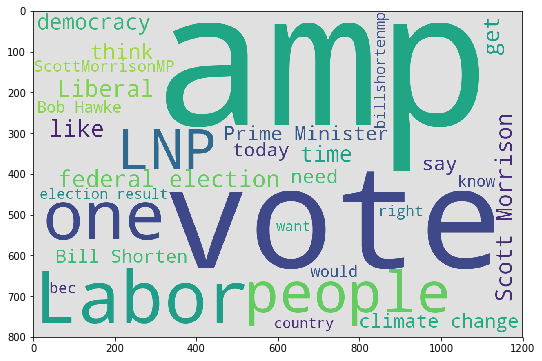

In [169]:
# DON'T DELETE
# nltk.download('stopwords')

# clearing emojis and non-english characters
text = X_train.astype('str').str.encode('utf-8').apply(lambda x: x.decode('ascii', 'ignore')).values

def make_wordcloud(text):
    # deleting all words contining AUS ignoring case
    text = list(map((lambda x: re.sub(r'[Aa]us\w{0,10}', ' ', x, flags=re.I)), text))
    # deleting links
    text = list(map(lambda x: re.sub('http\S*', '', x, flags=re.I), text))
    
    stop = stopwords.words('english')
    custom_stops = ['https', 'co', 'is', 'in', 'of', 'the', 'to',
                    'so', 'on', 'after', 'for', 'and', 'by', 'get', 'much']
    stop = stop+custom_stops
    wc = wordcloud.WordCloud(background_color='#e0e0e0', max_words=30, stopwords=stopwords.words('english'),
                         width=1200, height=800, random_state=42, regexp=r'(?u)\b\w\w+\b').generate(str(text))
    return wc
    
plt.figure(figsize=(10,6))
plt.imshow(make_wordcloud(text))

## Processing train part<a id='proc'></a>
Using count, tfidf and hasing vectorizers

In [13]:
count_vect = CountVectorizer(min_df=200, max_df=5000, ngram_range=(1,2))
%time X_train_count = count_vect.fit_transform(X_train)

Wall time: 11.8 s


In [14]:
%time text_count = count_vect.inverse_transform(X_train_count)

Wall time: 18 s


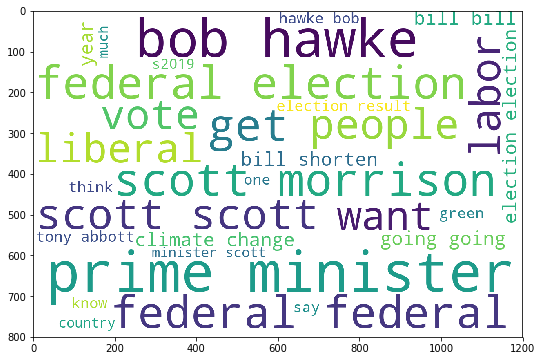

In [15]:
# demostrating differences before and after vectorizing
plt.figure(figsize=(10,6))
plt.imshow(make_wordcloud(list(map(str, text_count))))

In [16]:
# function to compare different vectorizers on default parameters
def use_vect(X, vect, decomposer, min_df=1, max_df=500000, n_features=50000, border=800, color='blue'):
    # creating vectorizer and transforming data
    if vect.__name__ != 'HashingVectorizer':
        vect = vect().set_params(min_df=min_df, max_df=max_df, ngram_range=(1,1))
    else:
        vect = vect().set_params(n_features=n_features)
    X = vect.fit_transform(X)
    
    N_features = X.sum(axis=0).shape[1]
    
    # decomposing data to visualize data
    X_de = decomposer().fit_transform(X)
    # getting random indices for plot
    random_indices = np.arange(X_de.shape[0])
    np.random.shuffle(random_indices)
    random_indices=random_indices[:border]
    
    # plot
    data=pd.DataFrame(X_de[random_indices, :])
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    # samples's locations in space
    axes[0].set_xlabel('1 component')
    axes[0].set_ylabel('2 component')
    axes[0].set_title('{0} features and {1} samples'.format(N_features, border))
    axes[0].scatter(x=data.iloc[:,0], y=data.iloc[:,1], s=1.75, color=color)
    #print(list(map(str, vect.inverse_transform(X))))
    try:
        axes[1].imshow(make_wordcloud(list(map(str, vect.inverse_transform(X)))))
    except AttributeError:
        pass

pattern of clusters depended on number of samples displayed 

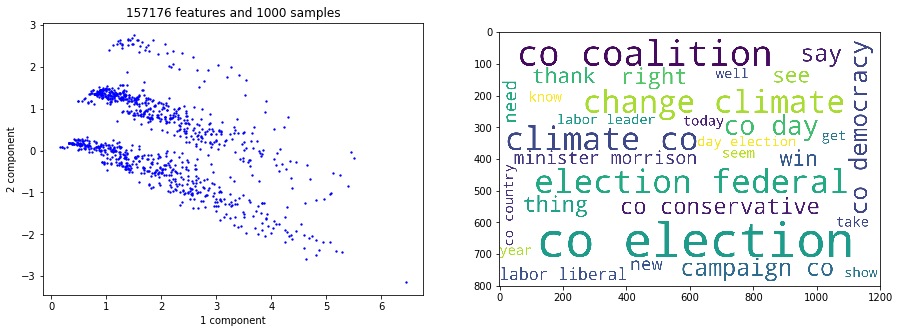

In [17]:
use_vect(X_train, CountVectorizer, TruncatedSVD, border=1000)

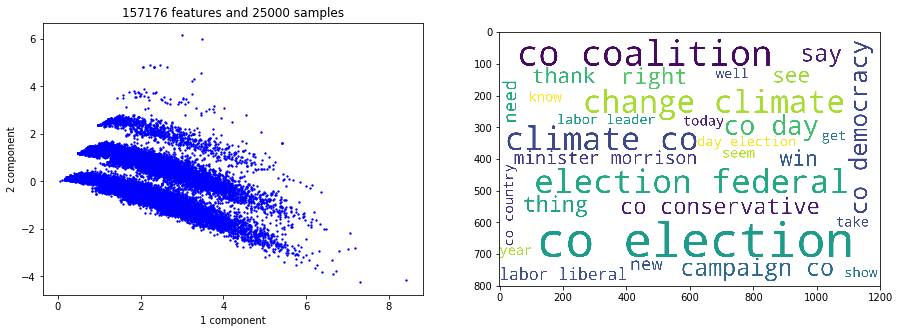

In [18]:
use_vect(X_train, CountVectorizer, TruncatedSVD, border=25000)

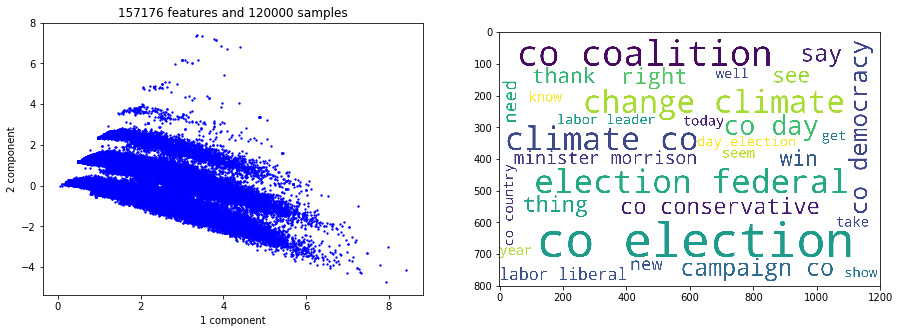

In [19]:
use_vect(X_train, CountVectorizer, TruncatedSVD, border=120000)

With increasing of number of samples used to plot clusters are getting more distinct so it's recommend to use most of all sapmles.


Investigating patterns of clusters depended on vectorizers's parameters

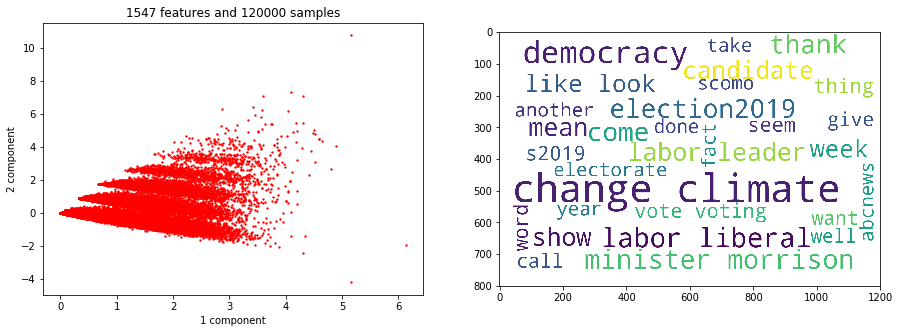

In [20]:
use_vect(X_train, CountVectorizer, TruncatedSVD, border=120000, min_df=200, max_df=25000, color='red')

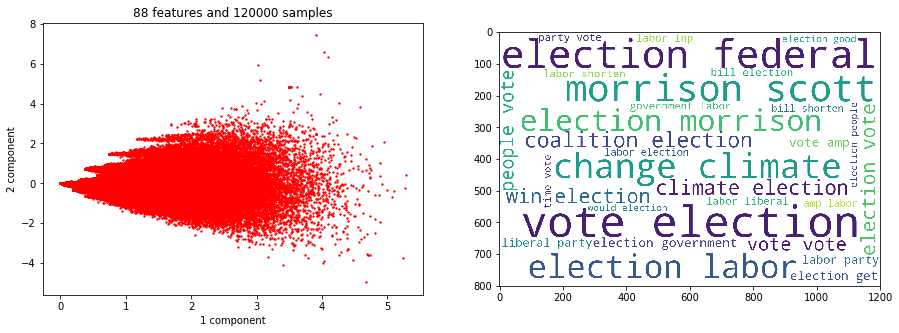

In [21]:
use_vect(X_train, CountVectorizer, TruncatedSVD, border=120000, min_df=4000, max_df=50000, color='red')

tfidf vectorizer

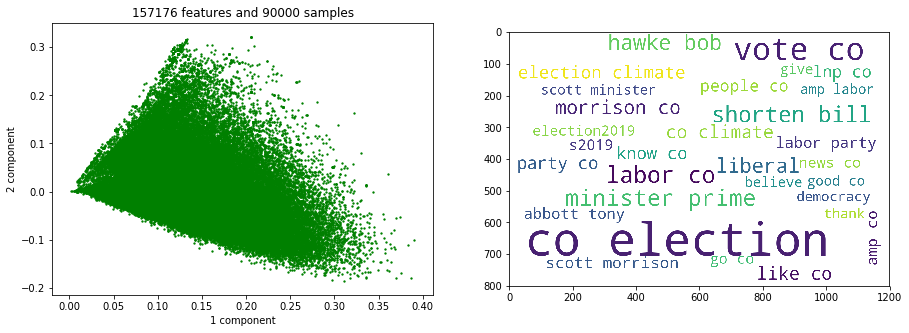

In [22]:
use_vect(X_train, TfidfVectorizer, TruncatedSVD, border=90000, n_features=500, color='green')

hash vectorizer

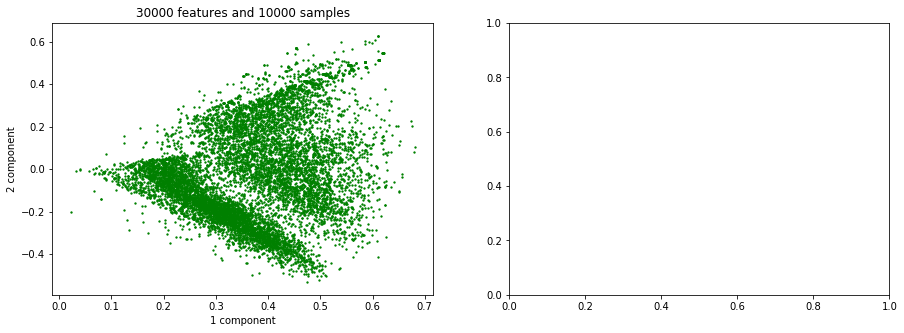

In [23]:
use_vect(X_train, HashingVectorizer, TruncatedSVD, n_features=30000, border=10000, color='green')

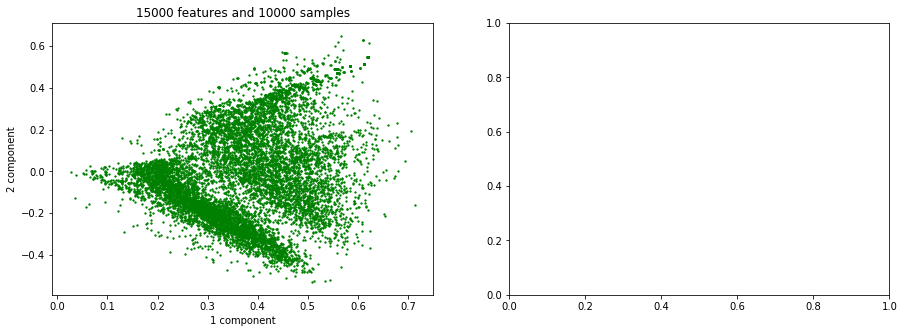

In [24]:
use_vect(X_train, HashingVectorizer, TruncatedSVD, n_features=15000, border=10000, color='green')

#### Results
Diffirent methods give different results as it shown on plots.
So, for clustering it's better to use count vectorizer as clusters have more distinct shape.
As shapes of clusters's shapes elongated it's rather to use DBSCAN.

### DBSCAN on CountVectorized data<a id='scan_on_vect'></a>

In [25]:
def visual_dbscans(X,y, border=130000, clusters_size_fixed=False):
    # decomposing for visualize
    decomposer = TruncatedSVD()
    X = decomposer.fit_transform(X)
    
    # getting random indices for plot
    random_indices = np.arange(X.shape[0])
    np.random.shuffle(random_indices)
    random_indices=random_indices[:border]
    
    data=pd.DataFrame(X)
    data=pd.concat([data, pd.Series(y, name=2), pd.Series(np.ones(data.shape[0]), name=3)], axis=1)
    # condition is for only non-border points
    cond = data.iloc[:,2] != -1
    
    # display only centers of clusters because as it turns out elemnts of each cluster concentrated in center of cluster
    # reasonably display only centers which size related to size of cluster itself
    
    sizes = data[cond].groupby([2]).sum()[3]
    sizes = sizes/7
    if clusters_size_fixed:
        sizes = 4
    
    # plot
    plt.figure(figsize=(12,7))
    plt.xlabel('1 component')
    plt.ylabel('2 component')
    
    #plt.xlim(1.1, 1.25); plt.ylim(1.5,1.7)
    
    n_centers = len(np.unique(y))-1
    n_cluster_points = data[cond].shape[0]
    
    plt.title('{0} samples, {1} centers and {2} cluster points'.format(border, n_centers, n_cluster_points))
    # samples's locations in space except noise samples
    plt.scatter(x=data.iloc[:,0][cond], y=data.iloc[:,1][cond], s=sizes, c=data.iloc[:,2][cond], alpha=0.2)
    

In [26]:
count_vect = CountVectorizer(min_df=400, max_df=20000, ngram_range=(1,3))
X_train_count = count_vect.fit_transform(X_train)

In [101]:
clusterer = DBSCAN(eps=0.1, min_samples=31)
%time clusterer.fit(X_train_count)

Wall time: 6min 11s


DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=31, n_jobs=None, p=None)

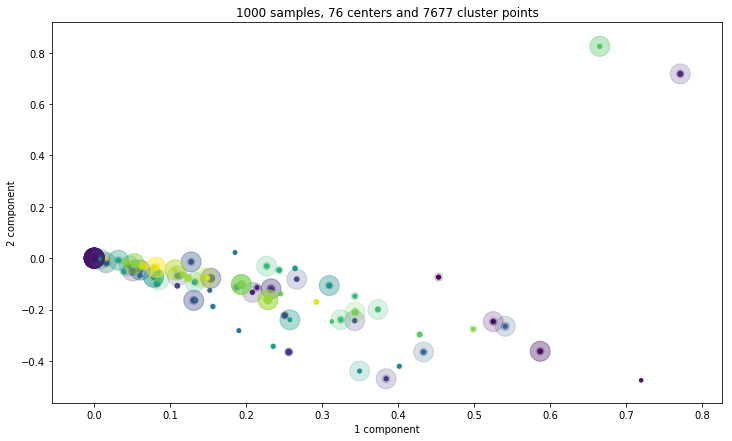

In [102]:
visual_dbscans(X_train_count, clusterer.labels_, border=1000)

In [209]:
biggest_clusters = pd.Series(clusterer.labels_).value_counts()[1:6].index
t=pd.concat([X_train, pd.Series(clusterer.labels_)], axis=1)

In [221]:
for cluster in biggest_clusters:
    print(t[t[0] == cluster].iloc[3, 0], '\n#################\n')

https://t.co/szcFn1GRMK https://t.co/JWoEDg9FZs 
#################

🤣 #auspol #ausvotes https://t.co/cHx8EwDxsd 
#################

#Auspol #AusVotes2019 https://t.co/inBQBqlxhw 
#################

Sanctimonious. Condescending. Irrelevant. Stick to comedy #ausvotes #auspol https://t.co/6RVjmYNvoW 
#################

"Australia's unexpected election result is being compared to Brexit and the 2016 US election"  https://t.co/Y30nC7KsEN 
#################



### DBSCAN on HashVectorized data<a id='scan_on_hash'></a>


In [29]:
hash_vect = HashingVectorizer(n_features = 1500)
X_train_hash = hash_vect.fit_transform(X_train)

In [30]:
# %time clusterer = DBSCAN(eps=0.1, min_samples=7).fit(X_train_hash)
# print(len(np.unique(clusterer.labels_))-1, 'clusters')
# visual_dbscans(X_train_hash, clusterer.labels_, border=133000)

# Feature engineering<a id='fe'></a>

In [31]:
# finding all account mentioned in text and description
mentioned_in_text = tweets['full_text'].str.findall('@\w+')
mentioned_in_descr = tweets['user_description'].str.findall('@\w+')

# transforming whole rows into strings
mentioned_in_text = mentioned_in_text.apply(str)
mentioned_in_descr = mentioned_in_descr.apply(str)

# extracting accounts's names
def join_mentions(row):
    row=row.replace('[', '')
    row=row.replace(']', '')
    row=row.replace("'", '')
    row=row.replace(",", '')
    return row
    
mentioned_in_text = mentioned_in_text.apply(join_mentions)
mentioned_in_descr = mentioned_in_descr.apply(join_mentions)

# vectorizing sparse matrixes of mentioned accounts
# countvectorized
X_ment_text = CountVectorizer().fit_transform(mentioned_in_text)
X_ment_descr = CountVectorizer().fit_transform(mentioned_in_descr)

# hashvectorized
X_ment_text_hash = HashingVectorizer().fit_transform(mentioned_in_text)
X_ment_descr_hash = HashingVectorizer().fit_transform(mentioned_in_descr)

# hashvectorized with reduced number of features
X_ment_text_hash_red = HashingVectorizer(n_features=1500).fit_transform(mentioned_in_text)
X_ment_descr_hash_red = HashingVectorizer(n_features=1500).fit_transform(mentioned_in_descr)

del mentioned_in_text
del mentioned_in_descr

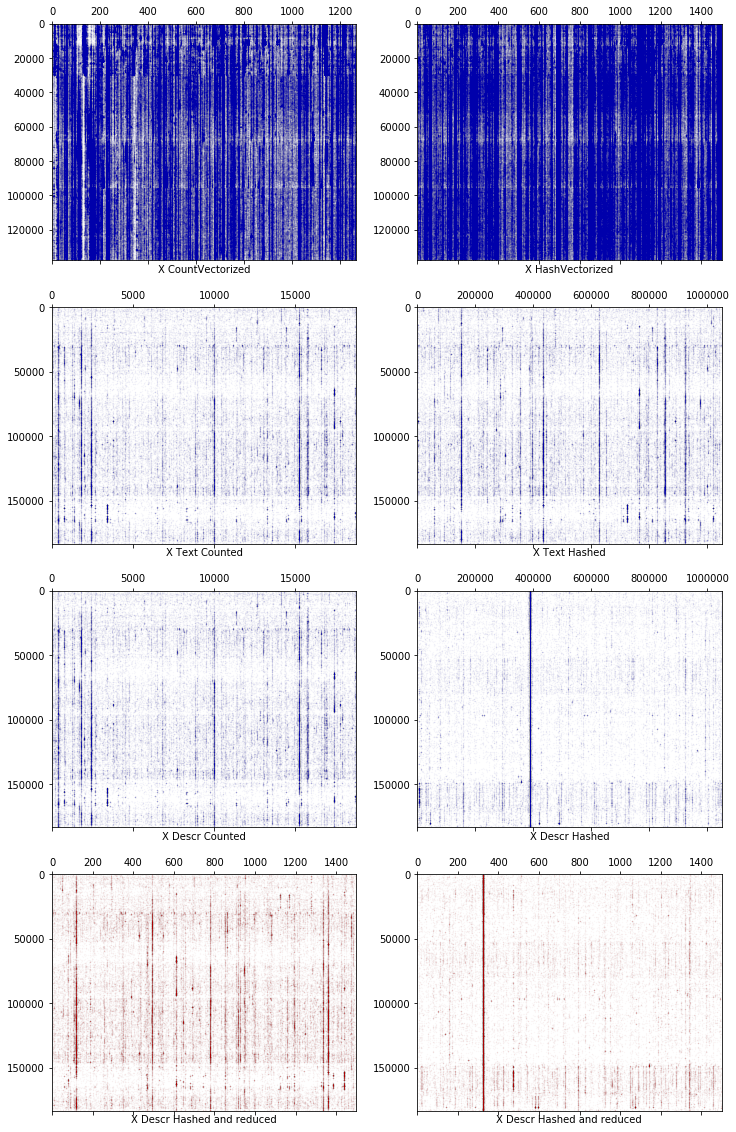

In [145]:
# plotting sparse matrixes
fig, axes = plt.subplots(4,2,figsize=(12,20))

var_s=[X_train_count, X_train_hash, X_ment_text, X_ment_text_hash,
       X_ment_text, X_ment_descr_hash, X_ment_text_hash_red, X_ment_descr_hash_red]
title_s=['X CountVectorized', 'X HashVectorized', 'X Text Counted', 'X Text Hashed',
         'X Descr Counted', 'X Descr Hashed', 'X Descr Hashed and reduced', 'X Descr Hashed and reduced']
color_s=[(0,0,0.67) for i in range(6)]+[(0.67, 0, 0), (0.67, 0, 0)]

for ax, var, title, c in zip(axes.flatten(), var_s, title_s, color_s):
    ax.spy(var, aspect='auto', markersize=0.004, c=c)
    ax.set_xlabel(title)
    
# patterns of counted and hashed matrixes are pretty similar so there is probably no reason to use hash vectorizing
# as they have much more features
# goal is group tweets by their content and interpret results
plt.show()

In [33]:
with open(os.path.join('data', 'X_descr_count.pkl'), 'wb') as f:
    pickle.dump(X_ment_descr, f, pickle.HIGHEST_PROTOCOL)

In [34]:
#%time ment_text_clusterer = DBSCAN(eps=0.0001, min_samples=21).fit(X_ment_text)
#%time ment_descr_clusterer = DBSCAN(eps=0.0001, min_samples=21).fit(X_ment_descr)
# matrixes too sparsed or parametres just not tuned 
# but apparently there is MemoryError

In [35]:
# link = 'https://yandex.ru/'
# headers = {"accept":'*/*',
#           'user-agent':'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.99 YaBrowser/19.1.0.2644 Yowser/2.5 Safari/537.36'}
# session = requests.Session()
# request = session.get(link, headers=headers)
# if request.status_code == 200:
#     print('Ok')
# else:
#     print("No")

In [116]:
tweets['day_block'] = tweets['created_at'].apply(lambda x: x.day)

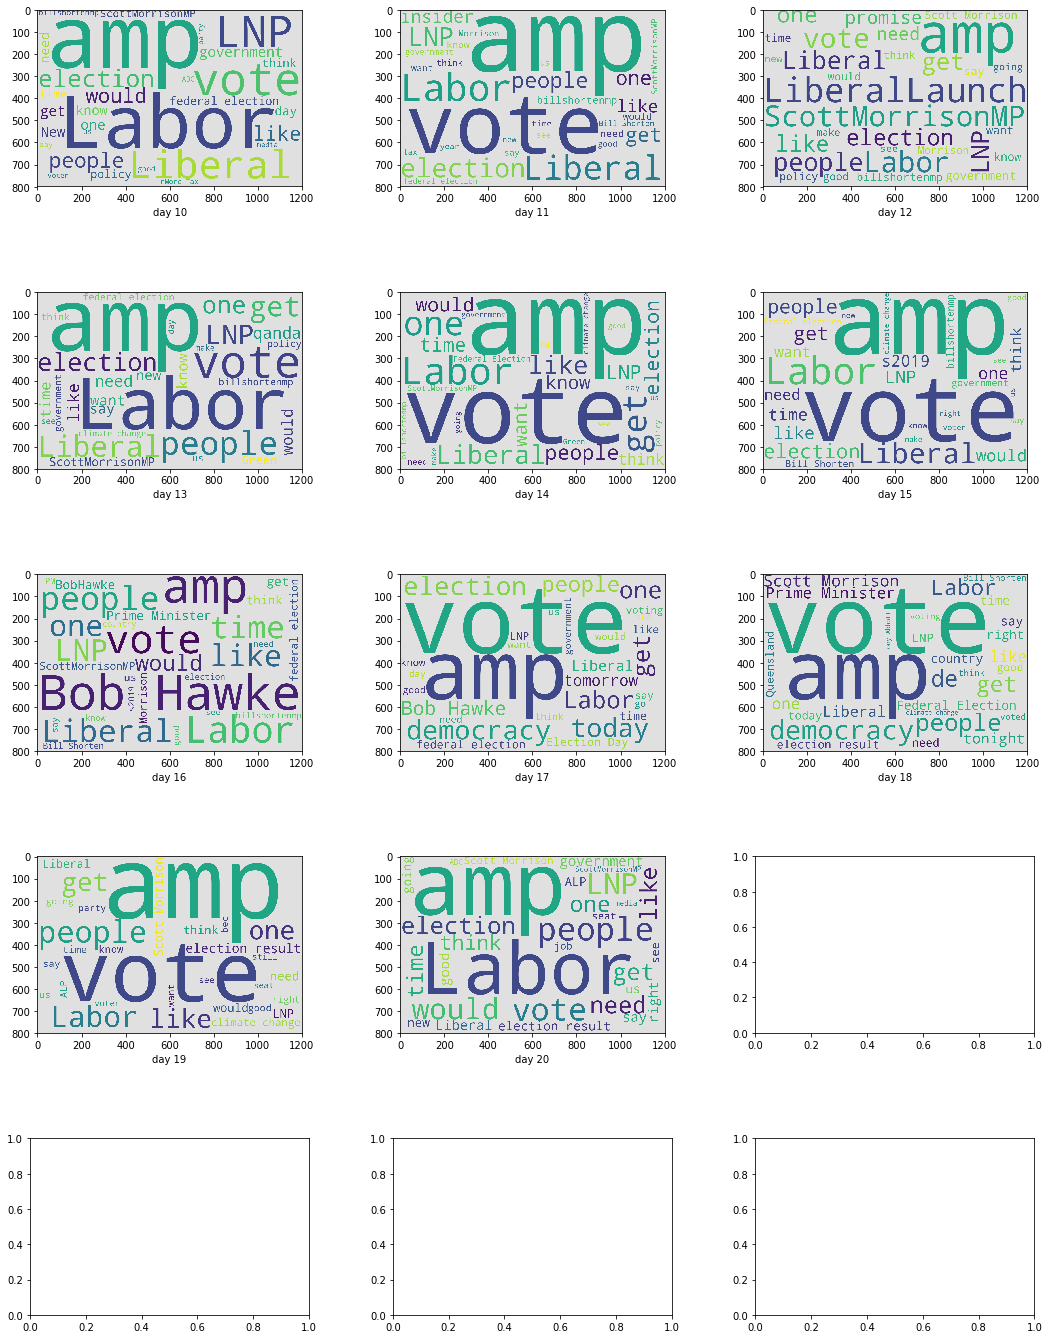

Wall time: 35.5 s


In [171]:
%%time
# wordclouds for each day
fig, axes = plt.subplots(5, 3, figsize=(18,24))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for ax, day in zip(axes.flatten(), np.flip(tweets['day_block'].unique())):
    text=tweets[tweets['day_block'] == day]['full_text']
    ax.imshow(make_wordcloud(text))
    ax.set_xlabel('day '+str(day))
plt.show()